load database and previous wisp

Loading flat from ../data/flat/jwst_nircam_flat_0645.fits


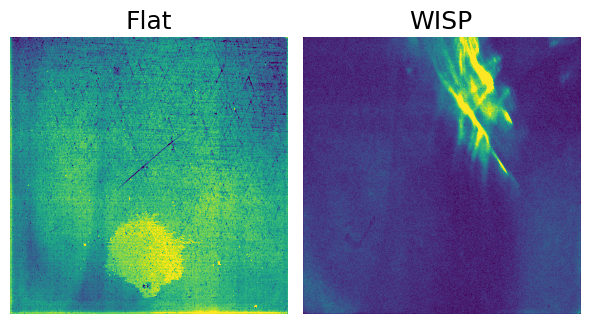

In [1]:
import numpy as np
from astropy.io import fits
from utils import *

DETECTOR, FILTER = 'nrcb4', 'F150W'
wisp_path = f'../data/wisp_templates/wisp_template_{FILTER.upper()}_{DETECTOR.lower()}.fits'
downsample = 4

flat = load_stsci_flat(DETECTOR, FILTER, downsample=downsample)
wisp, wisp_mask = load_stsci_wisp(wisp_path, downsample=downsample)
show_images([flat, wisp], ['Flat', 'WISP']);

In [2]:
from preprocess import calibrate_rates, correct_1f_noise
database_path = f'../data/{DETECTOR}_{FILTER}_full_4x4_v1.0-rate_pixdb.fits'
rates, error, dq, meta, mask = rectify_db(database_path, ndilate=2)
cal, cal_e, bg = calibrate_rates(rates, error, flat, mask, wisp_mask)
cal = correct_1f_noise(cal, mask, wisp_mask)

Filename: ../data/nrcb4_F150W_full_4x4_v1.0-rate_pixdb.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  SCI           1 ImageHDU         9   (512, 512, 379)   float32   
  2  ERR           1 ImageHDU         9   (512, 512, 379)   float32   
  3  DQ            1 ImageHDU        11   (512, 512, 379)   int32 (rescales to uint32)   
  4  META          1 BinTableHDU     36   379R x 13C   [64A, J, J, J, J, D, D, D, D, D, D, D, 4E]   


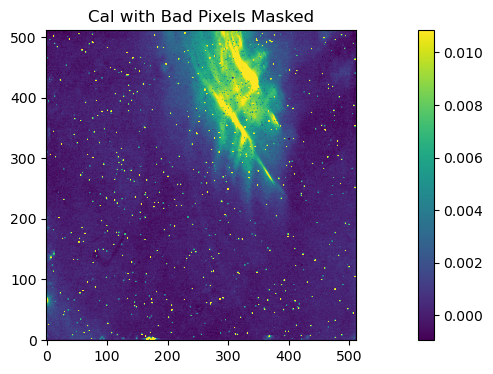

In [ ]:
stacked = show_stacked(cal, mask, 'Cal with Bad Pixels Masked', stack_func=np.nanmean, range=[1, 99])

In [ ]:
from preprocess import mask_bad_pixels
bad_pixel_mask = mask_bad_pixels(cal, cal_e, mask, std_threshold=10)
mask = mask | bad_pixel_mask

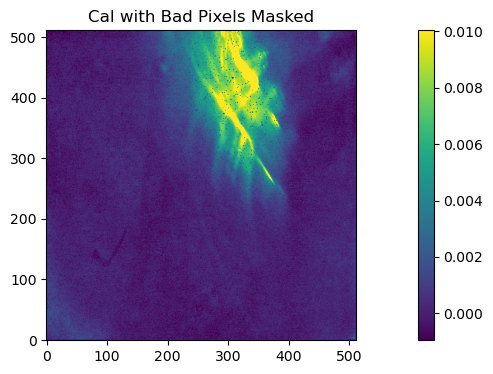

In [ ]:
stacked = show_stacked(cal, mask, 'Cal with Bad Pixels Masked', stack_func=np.nanmean, range=[1, 99])

In [ ]:
import os
save_path = f'./cache/{DETECTOR}_{FILTER}_data.fits'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
hdu_list = fits.HDUList()
hdu_list.append(fits.ImageHDU(cal, name='SCI'))
hdu_list.append(fits.ImageHDU(cal_e, name='ERR'))
hdu_list.append(fits.ImageHDU(mask.astype(np.uint8), name='MASK'))
hdu_list.append(fits.ImageHDU(np.atleast_2d(bg), name='BG'))
hdu_list.append(fits.BinTableHDU(meta, name='META'))
hdu_list.writeto(save_path, overwrite=True)

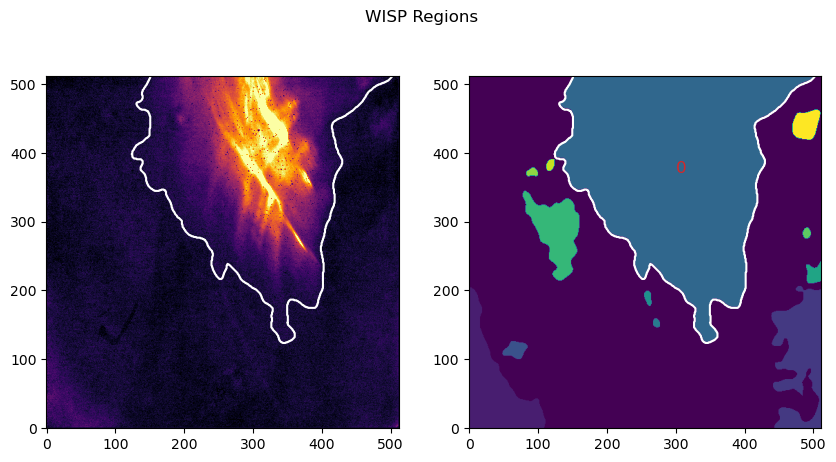

In [ ]:
from preprocess import build_wisp_regions, show_wisp_regions
wisp_regions, segmentmap = build_wisp_regions(stacked, max_comp_num=1, min_flux_ratio=0.01, threshold=0.21)
show_wisp_regions(stacked, wisp_regions, segmentmap, 'WISP Regions')
save_path = f'./cache/{DETECTOR}_{FILTER}_wisp_regions.fits'
hdu_list = fits.HDUList()
hdu_list.append(fits.ImageHDU(wisp_regions.astype(np.uint8), name='WISP_REGIONS'))
hdu_list.append(fits.ImageHDU(segmentmap.data, name='SEGMAP'))
hdu_list.writeto(save_path, overwrite=True)